In [47]:
%matplotlib inline
import sys
sys.path.append("../code/")

import config

#import igraph
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import seaborn as sns

import data_analysis_for_paper as dafp

sns.set_context("paper")
sns.set_style("ticks")

from collections import defaultdict
current_pal = sns.color_palette()

#%%
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = '%s%%' % n
    return percentile_

clean_lang = lambda x: x.replace("MergedCl","").replace("Cl","")



In [7]:
#%%
LANG_ORDER = ["Rust","JSCl","RubyMergedCl"]

DATASETS = {}

for lang in LANG_ORDER:
    print lang

    adoption_file = config.FINAL_DATA+"cleaned_{0}_adoption_final.csv"
    release_file = config.FINAL_DATA+"cleaned_{0}_release_final.csv"
    opts = {"na_filter": False}
    #%%

    df_adoption =  pd.read_csv(adoption_file.format(lang), **opts)
    df_release =  pd.read_csv(release_file.format(lang), **opts)

    df_fixed = pd.read_csv("../data/working/fixed_adopted_{0}_meta.csv".format(lang), sep="\t",**opts)
    df_fixed.loc[pd.isnull(df_fixed.orig_ver_string), "orig_ver_string"] = ""

    #%%

    df_fixed = df_fixed[df_fixed.commit_ts <= 1459468800]
    df_fixed = df_fixed[df_fixed.release_ts_y <= 1459468800]

    df_adoption = df_adoption[df_adoption.commit_ts <= 1459468800]
    df_release = df_release[df_release.release_ts <= 1459468800]


    df_fixed.loc[:,"commit_ts"] = pd.to_datetime(df_fixed.commit_ts, unit="s")
    df_fixed.loc[:,"release_ts_y"] = pd.to_datetime(df_fixed.release_ts_y, unit="s")
    df_adoption.loc[:,"commit_ts"] = pd.to_datetime(df_adoption.commit_ts, unit="s")
    df_release.loc[:,"release_ts"] = pd.to_datetime( df_release.release_ts, unit="s")
    
    DATASETS[lang] = (df_fixed, df_adoption, df_release)

Rust
JSCl
RubyMergedCl


/home/kikas/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
general_df = []
for lang in LANG_ORDER:
    lang_ = lang.replace("MergedCl","").replace("Cl","")
    (df_fixed, df_adoption, df_release) =   DATASETS[lang] 

    print "\nLang", lang

    rename_rules = {"adopted_name":"project_name", "adopted_github":"project_github"}

    no_pub = df_release.query("is_published==1")[["project_name", "project_github"]].drop_duplicates().shape[0]
    
    no_gh_ = df_release.query("is_published==0")[["project_name", "project_github"]].drop_duplicates()
    no_gh2_ =  df_fixed.query("is_published==0")[["project_name", "project_github"]].drop_duplicates()
    
    no_gh = pd.concat((no_gh_, no_gh2_)).drop_duplicates().shape[0]
    
    print "\nPublished projects", no_pub
    print "non-Published projects",no_gh
    #print "\nadoption projects", df_adoption[["project_name", "project_github"]].drop_duplicates().shape


    uniq_dep = df_fixed[["project_name", "project_github"]].drop_duplicates()
    uniq_dep_adopt = df_fixed[["adopted_name", "adopted_github"]].drop_duplicates().rename(columns=rename_rules)
    
    no_total =  pd.concat([df_adoption[["project_name", "project_github"]], df_release[["project_name", "project_github"]],uniq_dep_adopt,   uniq_dep]).drop_duplicates().shape[0]

    print "\nAll initial sample",no_total
    general_df.append([lang_, no_total, no_pub, no_gh])


Lang Rust

Published projects 11037
non-Published projects 0

All initial sample 11037

Lang JSCl

Published projects 254466
non-Published projects 84987

All initial sample 339453

Lang RubyMergedCl

Published projects 122786
non-Published projects 62133

All initial sample 184994


In [44]:
general_stats = pd.DataFrame.from_records(general_df,columns=["lang", "total", "published","github"])
print general_stats

   lang   total  published  github
0  Rust   11037      11037       0
1    JS  339453     254466   84987
2  Ruby  184994     122786   62133


In [13]:
#eg_evo, ver_evo = dafp.get_evo_data(lang)
summary_df = []

for lang in LANG_ORDER:
    lang_ = lang.replace("MergedCl","").replace("Cl","")
    (df_fixed, df_adoption, df_release) =   DATASETS[lang] 

    print "\nLang", lang

    rename_rules = {"adopted_name":"project_name", "adopted_github":"project_github"}


    #print "total projects net", pd.concat([uniq_dep, uniq_dep_adopt]).drop_duplicates().shape
    #print "unique adopted projects net", uniq_dep_adopt.shape
    #print "projects that have dependencies net", uniq_dep.shape


    #rename_rules["adopted_ver"] = "project_ver"
    #concs =  pd.concat([df_fixed[["project_name", "project_github", "project_ver"]], df_fixed[["adopted_name", "adopted_github", "adopted_ver"]].rename(columns=rename_rules)])
    #print "\nProject in the graph",concs.drop_duplicates().shape



    funcs =  [np.min, percentile(5), np.mean, np.median,percentile(95),np.max  ]
    lbls = ["min","5p","mean","median","95p","max"]
    #vers1 =  df_fixed[["project_name", "project_github", "project_ver", "adopted_github"]].groupby(["project_name", "project_github", "project_ver"]).agg({"adopted_github":lambda x: len(x.unique())}).reset_index()
    #deps_per_ver = [fn(vers1["adopted_github"].values) for fn in funcs]

    vers1 =  df_fixed[["project_name", "project_github", "adopted_github", "adopted_ver"]].groupby(["project_github",  "adopted_github"]).agg({"adopted_ver":lambda x: len(x.unique())}).reset_index()
    implicit = [fn(vers1["adopted_ver"].values) for fn in funcs]
    vers1 =  df_fixed[["project_name", "project_github", "adopted_github", "orig_ver_string"]].groupby([ "project_github",  "adopted_github"]).agg({"orig_ver_string":lambda x: len(x.unique())}).reset_index()
    explicit = [fn(vers1["orig_ver_string"].values) for fn in funcs]

    df_stats =  pd.DataFrame({"label":lbls, "implicit":implicit, "explicit":explicit})
    df_stats.loc[:,"lang"] = lang_
    summary_df.append(df_stats)
    print df_stats

    
    #uniq_dep_adopt = df_fixed[["adopted_name", "adopted_github", "adopted_ver"]].drop_duplicates()
    #print "\ntotal project, versions ever adopted", uniq_dep_adopt.shape
    #print "\ntotal adoptions, vernode links", df_fixed.shape[0]

    #last_month = "2016-04-01"
    #uniq_dep_adopt = df_fixed[df_fixed.commit_ts > last_month][["adopted_name", "adopted_github", "adopted_ver"]].drop_duplicates()

    #print "\nversions active during last month", uniq_dep_adopt.shape


Lang Rust

Published projects 11037
non-Published projects 0

All initial sample 11037
    explicit   implicit   label  lang
0   1.000000   1.000000     min  Rust
1   1.000000   1.000000      5p  Rust
2   1.192546   1.441691    mean  Rust
3   1.000000   1.000000  median  Rust
4   2.000000   4.000000     95p  Rust
5  62.000000  63.000000     max  Rust

Lang JSCl

Published projects 254466
non-Published projects 84987

All initial sample 339453
     explicit   implicit   label lang
0    1.000000    1.00000     min   JS
1    1.000000    1.00000      5p   JS
2    1.250843    1.46833    mean   JS
3    1.000000    1.00000  median   JS
4    2.000000    4.00000     95p   JS
5  253.000000  280.00000     max   JS

Lang RubyMergedCl

Published projects 122786
non-Published projects 0

All initial sample 184994
     explicit    implicit   label  lang
0    1.000000    1.000000     min  Ruby
1    1.000000    1.000000      5p  Ruby
2    1.282047    1.981791    mean  Ruby
3    1.000000    1.000000  m

In [16]:
updates_df = pd.concat(summary_df)

updates_df.to_csv("../paper/tables/update_counts.csv", index=None)

In [26]:
pivoted = pd.pivot_table(updates_df, index="lang", columns="label")

print pivoted

mi = pd.MultiIndex.from_product([['explicit', 'implicit'], ['min','5p','median','mean', '95p','max']])

pivoted_order = pivoted.reindex_axis(mi, 1)


with open("../paper/tables/update.tex","w") as fp:
    fp.write(pivoted_order.to_latex(float_format='%.2f'))


      explicit                                   implicit              \
label       5p  95p    max      mean median  min       5p  95p    max   
lang                                                                    
JS         1.0  2.0  253.0  1.250843    1.0  1.0      1.0  4.0  280.0   
Ruby       1.0  2.0  343.0  1.282047    1.0  1.0      1.0  6.0  344.0   
Rust       1.0  2.0   62.0  1.192546    1.0  1.0      1.0  4.0   63.0   

                             
label      mean median  min  
lang                         
JS     1.468330    1.0  1.0  
Ruby   1.981791    1.0  1.0  
Rust   1.441691    1.0  1.0  


In [38]:
stacked = pd.pivot_table(pd.melt(updates_df,id_vars=["lang","label"]), index=["variable","lang"], columns="label")
mi2 = pd.MultiIndex.from_product([['value'], ['min','5p','median','mean', '95p','max']])
stacked = stacked.reindex_axis(mi2,1)
stacked
with open("../paper/tables/update_stacked.tex","w") as fp:
    fp.write(stacked.to_latex(float_format='%.2f'))

# TOTAL GRAPH

In [75]:

rows = []
for lang_ in LANG_ORDER:
    lang = clean_lang(lang_)
    re, ve = dafp.get_evo_data(lang)
    last_v =  re.sort("date").tail(1)[["nodes","unique_relations","github_nodes","published_nodes"]]
    last_v = last_v.rename(columns={"nodes":"projects","unique_relations":"project_depedencies"})
    last_r = ve.sort("date").tail(1)[["nodes","version_relations"]]
    last_r = last_r.rename(columns={"nodes":"releases","version_relations":"release_dependencies"})
    
    row =  pd.concat((last_v, last_r), axis=1)
    if lang == "Rust":
        row.loc[:,"published_nodes"] = row.loc[:,"projects"]
        row.loc[:,"github_nodes"] = 0
    row.loc[:,"lang"] = lang
    rows.append(row)
    
totals = pd.concat(rows).set_index("lang")

2016-10-15 14:56:46,542 - INFO - Entering get_evo_data:lang='Rust'
2016-10-15 14:56:46,574 - INFO - Exiting get_evo_data:lang='Rust', took 0.029 s
/gfs22/biit/home/kikas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/gfs22/biit/home/kikas/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
2016-10-15 14:56:46,593 - INFO - Entering get_evo_data:lang='JS'
2016-10-15 14:56:46,622 - INFO - Exiting get_evo_data:lang='JS', took 0.028 s
2016-10-15 14:56:46,639 - INFO - Entering get_evo_data:lang='Ruby'
2016-10-15 14:56:46,672 - INFO - Exiting get_evo_data:lang='Ruby', took 0.031 s


In [76]:
print totals

print general_stats

totals2 = pd.merge(totals, general_stats.set_index("lang")[["github","published"]], left_index=True, right_index=True)

      projects  project_depedencies  github_nodes  published_nodes  releases  \
lang                                                                           
Rust      7978                25144             0             7978     22105   
JS      246670              1182114         78657           168013   1319919   
Ruby    147449               776061         69544            77905   1231480   

      release_dependencies  
lang                        
Rust                 66055  
JS                 7260426  
Ruby              10747737  
   lang   total  published  github
0  Rust   11037      11037       0
1    JS  339453     254466   84987
2  Ruby  184994     122786   62133


In [77]:

ltable = (totals2*1.0).to_latex(float_format=lambda x:  '{:,.0f}'.format(x))
print ltable

with open("../paper/tables/general_stat.tex","w") as fp:
    fp.write(ltable)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  projects &  project\_depedencies &  github\_nodes &  published\_nodes &  releases &  release\_dependencies &  github &  published \\
lang &           &                      &               &                  &           &                       &         &            \\
\midrule
Rust &     7,978 &               25,144 &             0 &            7,978 &    22,105 &                66,055 &       0 &     11,037 \\
JS   &   246,670 &            1,182,114 &        78,657 &          168,013 & 1,319,919 &             7,260,426 &  84,987 &    254,466 \\
Ruby &   147,449 &              776,061 &        69,544 &           77,905 & 1,231,480 &            10,747,737 &  62,133 &    122,786 \\
\bottomrule
\end{tabular}



In [71]:
totals2

,projects,project_depedencies,github_nodes,published_nodes,releases,release_dependencies,github_nodes,published_nodes,github,published
lang,,,,,,,,,,
Rust,7978,25144,0,7978,22105,66055,0,7978,0,11037
JS,246670,1182114,78657,168013,1319919,7260426,163618,1156301,84987,254466
Ruby,147449,776061,69544,77905,1231480,10747737,705927,525553,62133,122786


In [11]:
print totals.project_depedencies / totals.projects
print totals.release_dependencies / totals.releases


lang
Rust    3.151667
JS      4.792289
Ruby    5.263250
dtype: float64
lang
Rust    2.988238
JS      5.500660
Ruby    8.727496
dtype: float64


# FINAL MONTH STATS

In [28]:
final_reg = pd.read_csv("../paper/figures/last_month_data_reg.csv.gz")
final_ver = pd.read_csv("../paper/figures/last_month_data_ver.csv.gz")

In [29]:
final_reg[["outdegree", "indegree","dependencies_unique", "dependents_unique", "lang","dependencies_unique_direct","dependents_unique_direct"]].groupby("lang").mean()

,outdegree,indegree,dependencies_unique,dependents_unique,dependencies_unique_direct,dependents_unique_direct
lang,,,,,,
JS,4.792289,4.792289,1055.561588,1055.561588,4.792289,4.792289
Ruby,5.263250,5.263250,115.081350,115.081350,5.263250,5.263250
Rust,3.151667,3.151667,28.361619,28.361619,3.151667,3.151667


In [15]:
final_ver[["lang","indegree"]].groupby("lang").count()

,indegree
lang,
JS,1246856
Ruby,1213562
Rust,20913


In [20]:
final_ver.lang.value_counts()

JS      1246856
Ruby    1213562
Rust      20913
Name: lang, dtype: int64

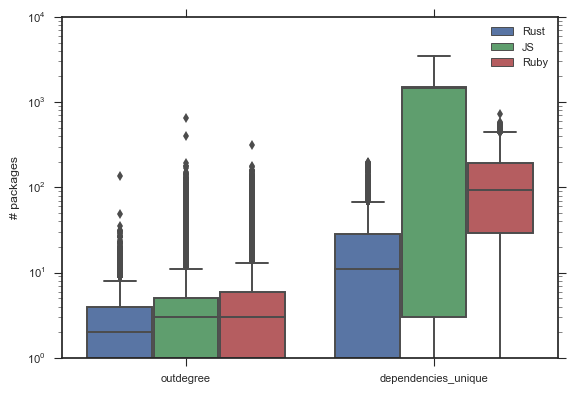

In [35]:
data = pd.melt(final_reg[["project_github","lang", "outdegree", "dependencies_unique"]],
                   id_vars=[ 'lang', 'project_github'])

fig, ax = plt.subplots()

sns.boxplot(data=data,#.query('value > 0'),
                x='variable', y='value', hue='lang', ax=ax)
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('# packages')
ax.legend(title='')
plt.show()